# U-net-resnet152

In [1]:

from PIL import Image
import torch
from tensorboard.summary.v1 import image
from torch import Tensor, nn
from torchvision import io
import numpy as np
from torchvision.transforms import functional
import os
import segmentation_models_pytorch as smp

## 一， utils

In [2]:


def keep_image_size(path: str, size=(256, 256)) -> Image.Image:
    img = Image.open(path)
    max_size=max(img.size)
    mask = Image.new('RGB', (max_size, max_size), (0, 0, 0))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

def keep_mask_image_size(path: str, size=(256, 256)) -> Image.Image:
    img = Image.open(path).convert("L")
    max_size=max(img.size)
    mask = Image.new('L', (max_size, max_size), 0)
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

def pad_16(image: Tensor) -> Tensor:
    width,height= functional.get_image_size(image)
    pad_height = (16 - height % 16) % 16
    pad_width = (16 - width % 16) % 16
    # 表示在左、右,上、下、四个方向 mode：指定填充模式，可以是 “constant”、“reflect” 或 “replicate”；
    pad_image = nn.functional.pad(image, (0, pad_width , 0, pad_height), mode='reflect')
    return pad_image

def pad_32(image: Tensor) -> Tensor:
    width,height= functional.get_image_size(image)
    pad_height = (32 - height % 32) % 32
    pad_width = (32 - width % 32) % 32
    # 表示在左、右,上、下、四个方向 mode：指定填充模式，可以是 “constant”、“reflect” 或 “replicate”；
    pad_image = nn.functional.pad(image, (0, pad_width , 0, pad_height), mode='reflect')
    return pad_image    

def show_image_memory_size(path: str):
    img = io.read_image(path)
    print(f"img shape:{img.shape}")
    print(f"data type:{img.dtype}")

    total_bytes = img.shape[0] * img.shape[1] * img.shape[2] * img.dtype.itemsize
    print(f"total bytes:{total_bytes},MB:{total_bytes/(1024*1024)}")



## 二， 定义模型

In [3]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)


class DownSimple(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.layer(x)


class UpSimple(nn.Module):
    def __init__(self, in_channels,out_channels):
        super().__init__()
        # 上采样 channel 减半
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        # 卷积 channel 减半
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, up_x, cat_left_x):
        upx = self.up(up_x)
        # 注意 链接时左右
        x = torch.cat((cat_left_x, upx), dim=1)
        return self.double_conv(x)


class Unet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.input = DoubleConv(in_channel, 64)

        self.down1 = DownSimple(64, 128)
        self.down2 = DownSimple(128, 256)
        self.down3 = DownSimple(256, 512)
        self.down4 = DownSimple(512, 1024)

        self.up4 = UpSimple(1024,512)
        self.up3 = UpSimple(512,256)
        self.up2 = UpSimple(256,128)
        self.up1 = UpSimple(128,64)

        self.output = nn.Conv2d(64, out_channel, kernel_size=1)

    def forward(self, x):
        x1 = self.input(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        up4 = self.up4(x5,x4)
        up3 = self.up3(up4,x3)
        up2 = self.up2(up3,x2)
        up1 = self.up1(up2,x1)
        output= self.output(up1)

        return torch.sigmoid(output)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.layer(x)


class UNetPlus(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.cov00 = DoubleConv(in_channels, 64)
        self.cov10 = DoubleConv(64, 128)
        self.cov20 = DoubleConv(128, 256)
        self.cov30 = DoubleConv(256, 512)
        self.cov40 = DoubleConv(512, 1024)

        self.cov01 = DoubleConv(64 + 128, 64)
        self.cov11 = DoubleConv(128 + 256, 128)
        self.cov21 = DoubleConv(256 + 512, 256)
        self.cov31 = DoubleConv(512 + 1024, 512)

        self.cov02 = DoubleConv(64 + 64 + 128, 64)
        self.cov12 = DoubleConv(128 + 128 + 256, 128)
        self.cov22 = DoubleConv(256 + 256 + 512, 256)

        self.cov03 = DoubleConv(64 + 64 + 64 + 128, 64)
        self.cov13 = DoubleConv(128 + 128 + 128 + 256, 128)

        self.cov04 = DoubleConv(64 + 64 + 64 + 64 + 128, 64)

        self.final = nn.Conv2d(64, out_channels,kernel_size=1)

    def forward(self, x):
        x00 = self.cov00(x)
        x10 = self.cov10(self.down(x00))
        x01 = self.cov01(torch.cat([x00, self.up(x10)], dim=1))

        x20 = self.cov20(self.down(x10))
        x11 = self.cov11(torch.cat([x10, self.up(x20)], dim=1))
        x02 = self.cov02(torch.cat([x00, x01, self.up(x11)], dim=1))

        x30 = self.cov30(self.down(x20))
        x21 = self.cov21(torch.cat([x20, self.up(x30)], dim=1))
        x12 = self.cov12(torch.cat([x10, x11, self.up(x21)], dim=1))
        x03 = self.cov03(torch.cat([x00, x01, x02, self.up(x12)], dim=1))

        x40 = self.cov40(self.down(x30))
        x31 = self.cov31(torch.cat([x30, self.up(x40)], dim=1))
        x22 = self.cov22(torch.cat([x20, x21, self.up(x31)], dim=1))
        x13 = self.cov13(torch.cat([x10, x11, x12, self.up(x22)], dim=1))
        x04 = self.cov04(torch.cat([x00, x01, x02, x03, self.up(x13)], dim=1))

        final= self.final(x04)
        return torch.sigmoid(final)





## 三，dataset

In [5]:
import os
import torch
from functorch.dim import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import shutil
import random

transform = transforms.Compose([
    transforms.ToTensor()
])

# 路径，和最大 图片像素
class WaterDataset(Dataset):
    def __init__(self, path,max_size=2000_000):
        super().__init__()
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []
        self.max_size=max_size

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            # 图片太大，进行等比列缩放-内存不足

            width, height = image.size
            pixel_num = width * height
            if pixel_num > self.max_size:
                scale_factor = self.max_size / pixel_num
                new_width = int(width * scale_factor)
                new_height = int(height * scale_factor)
                # 缩放图像,建议双线性插值
                image = image.resize((new_width, new_height), resample=Image.LANCZOS)
                mask_image = mask_image.resize((new_width, new_height), resample=Image.LANCZOS)

            image = transform(image)
            mask_image = transform(mask_image)

            return pad_32(image), pad_32(mask_image)
        except Exception as e:
            print(f"数据错误: {image_path}", e)
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


transform512 = transforms.Compose([
    transforms.Resize(512),  # 保持长宽比，调整最短边为512像素
    transforms.CenterCrop(512),  # 从中心裁剪512x512的图片
    transforms.ToTensor()  # 转换成Tensor，方便后续处理
])


class WaterDataset512(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            image = transform512(image)
            mask_image = transform512(mask_image)

            return image, mask_image
        except  Exception as e:
            print(f"数据错误: {image_path},{e}")
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


# 图像数据增强
class ExtendTransform:
    # 图像数据进行增强，
    # ["original", "h_flip", "v_flip", "rotate_90", "rotate_180", "rotate_270"]
    def __init__(self, transform_type_list=["original", "h_flip"]):
        self.transform_type_list = transform_type_list

    def __call__(self, image, mask):

        image, mask = functional.to_tensor(image), functional.to_tensor(mask)
        type = random.choice(self.transform_type_list)

        if type == "original":
            return image, mask
        if type == "h_flip":
            return functional.hflip(image), functional.hflip(mask)
        if type == "v_flip":
            return functional.vflip(image), functional.vflip(mask)
        if type == "rotate_90":
            return functional.rotate(image, 90, expand=True), functional.rotate(mask, 90, expand=True)
        if type == "rotate_180":
            return functional.rotate(image, 180), functional.rotate(mask, 180)
        if type == "rotate_270":
            return functional.rotate(image, 270, expand=True), functional.rotate(mask, 270, expand=True)


extend_transforms = ExtendTransform()


class ExtendWaterDataset(Dataset):
    def __init__(self, path, max_size=2000_000, extend_flag=True):
        super().__init__()
        # 数据是否进行增强
        self.extend_flag = extend_flag
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []
        self.max_size = max_size

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            # 图片太大，进行等比列缩放-内存不足
            width, height = image.size
            pixel_num = width * height
            if pixel_num > self.max_size:
                scale_factor = self.max_size / pixel_num
                new_width = int(width * scale_factor)
                new_height = int(height * scale_factor)
                # 缩放图像,建议双线性插值
                image = image.resize((new_width, new_height), resample=Image.LANCZOS)
                mask_image = mask_image.resize((new_width, new_height), resample=Image.LANCZOS)

            # 是否增强
            if self.extend_flag:
                image, mask_image = extend_transforms(image, mask_image)
            else:
                image = transform(image)
                mask_image = transform(mask_image)

            return pad_16(image), pad_16(mask_image)
        except Exception as e:
            print(f"数据错误: {image_path}", e)
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


## 四，训练

找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00.json  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/label.png  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/label_viz.png  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/info.yaml  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/label_names.txt  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/img.png  ｛image_path_jpg｝


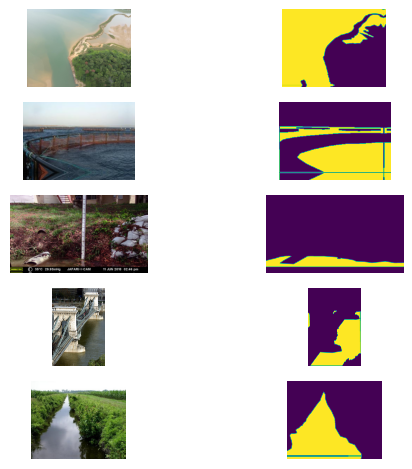

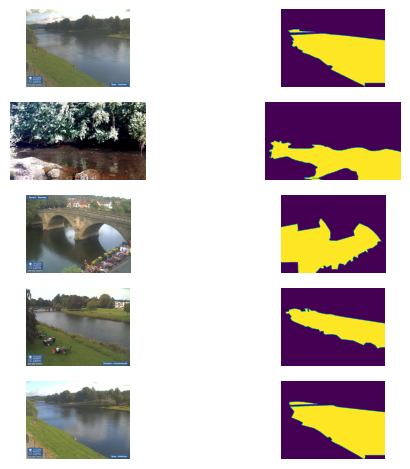

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 16.0MB/s]
[4/100]:   1%|          | 79/6414 [00:04<06:10, 17.11it/s, loss=14.5, train_miou=0.733]


KeyboardInterrupt: 

In [6]:
import torch
from torch.optim import *
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import functional, transforms
from torchvision.transforms.v2 import ToPILImage

import logging
from torchmetrics.segmentation import MeanIoU

from copy import deepcopy
from  tqdm import  trange,tqdm
from colorama import Fore
# 训练停止条件，连续 多少次没有增长
class TrainStop:
    def __init__(self, count=3):
        self.count = count
        self.score_list = [0.0]
        self.best = 0.0
        self.trigger_count = 0

    def __call__(self, score: float) -> bool:
        self.score_list.append(score)
        total = sum(self.score_list[-self.count:])
        # 最佳分数： 最后几次平均分
        mean = total / self.count
        if mean > self.best:
            self.best = mean

        # 分数没有超过之前，已经 count 次，就停止
        if self.best > score:
            self.trigger_count += 1
            if self.trigger_count > self.count + 1:
                return True

        return False


# 日志
def config_logger(name="train"):
    # 设置日志的基本配置
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    logger = logging.getLogger("train")
    logger.setLevel(logging.DEBUG)

    # 创建一个handler，用于写入日志文件
    file_handler = logging.FileHandler('app.log')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    # # 再创建一个handler，用于输出到控制台
    # stream_handler = logging.StreamHandler()
    # stream_handler.setFormatter(formatter)
    # logger.addHandler(stream_handler)

    return logger


# 合并datasets
def merge_datasets(dataset_list):
    image_path_list = []
    mask_path_list = []
    for dataset in dataset_list:
        image_path_list = image_path_list + dataset.image_path_list
        mask_path_list = mask_path_list + dataset.mask_path_list

    new_dataset = WaterDataset(dataset_list[0].path,max_size=2000_000)
    new_dataset.image_path_list = image_path_list
    new_dataset.mask_path_list = mask_path_list

    return new_dataset


def show_images(dataloader,num=3):
    to_pil_image = ToPILImage()
    plt.figure()
    for i in range(1,num*2,2):
       imgs,masks=  dataloader.dataset[i]
       plt.subplot(num, 2,i)
       plt.imshow(to_pil_image(imgs))
       plt.axis('off')

       plt.subplot(num, 2, i+1)
       plt.imshow(to_pil_image(masks))
       plt.axis('off')

    plt.tight_layout()  # 调整子图间距
    plt.show()




logger = config_logger()
train_stop = TrainStop(count=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



dataset1 = WaterDataset("../imags/water-3")
dataset2 = WaterDataset("../imags/water-v2-date-title")
dataset3 = WaterDataset("../imags/water_v1/water_v1")
dataset4 = WaterDataset("../imags/water_v2/water_v2")


dataset = merge_datasets([dataset1, dataset2,dataset3,dataset4])

# 每次都生成一样
generator = torch.Generator().manual_seed(666)
total_length = len(dataset)
var_length = int(total_length * 0.1)
train_dataset, val_dataset = random_split(dataset, [total_length - var_length, var_length],generator=generator)

#深复制验证集-验证-数据不进行增强，保持一致
val_dataset = deepcopy(val_dataset)
val_dataset.dataset.extend_flag=False

train_dataloader = DataLoader(dataset=train_dataset, batch_size=1)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1)

logger.info(f"训练数据: {len(train_dataloader)}  测试训练数据: {len(val_dataloader)} ")

show_images(val_dataloader,5)
show_images(train_dataloader,5)


# model = UNetPlus(3, 1).to(device)
# model= torch.load("unet-puls-0.pth")
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)
loss = nn.BCELoss().to(device)
optimizer = Adam(model.parameters(), 0.001)
mean_iou = MeanIoU(num_classes=2).to(device)

for epoch in range(100):
    # 训练
    model.train()
    total_loss = 0
    train_mean_iou=0
    mean_iou.reset()
    train_bar=tqdm(train_dataloader,total=len(train_dataloader),leave=True, postfix=Fore.GREEN)
    train_bar.set_description(f"[{epoch}/100]")
    for step, (images, mask_images) in enumerate(train_bar):
        images, mask_images = images.to(device), mask_images.to(device)
        height, width = functional.get_image_size(images)

        if images.shape[1] > 3:
            continue
        if mask_images.shape[1] > 1:
            continue
        if images.shape[2] == 1:
            continue

        model_result = model(images)

        loss_result = loss(model_result, mask_images)

        optimizer.zero_grad()
        loss_result.backward()
        optimizer.step()

        # 指标
        total_loss += loss_result.item()
        mean_iou.update((model_result > 0.5).long(), mask_images.long())

        train_mean_iou = mean_iou.compute().item() 
        train_bar.set_postfix(train_miou=train_mean_iou, loss=total_loss)

 


    # 验证
    model.eval()
    mean_iou.reset()
    var_mean_iou = 0
    var_bar = tqdm(val_dataloader, total=len(val_dataloader), leave=True, postfix=Fore.RED)
    var_bar.set_description(f"[{epoch}/100]")
    with torch.no_grad():
        for step, (images, targets) in enumerate(var_bar) :
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            # 阈值化并转换为整数类型
            outputs = (outputs > 0.5).long()
            mean_iou.update((outputs > 0.5).long(), targets.long())
            var_mean_iou = mean_iou.compute().item() 
            var_bar.set_postfix(var_miou=var_mean_iou)
 
    torch.save(model, f"unet-resnet152-{epoch}.pth")   
    logger.info(f"第epoch:{epoch} var-miou:{var_mean_iou} train-miou:{train_mean_iou} total_loss:{total_loss} pth: unet-plus{epoch}.pth")
 
    # 是否停止
    is_stop = train_stop(var_mean_iou)
    if is_stop:
        logger.info(f"停止训练: epoch:{epoch} 最佳iou {train_stop.best} , score_list:{train_stop.score_list}")
        print(f"停止训练: epoch:{epoch} 最佳iou {train_stop.best} , score_list:{train_stop.score_list}")
        break
